## Option Pricing

In [37]:
from QuantumMC.quantummc import QuantumMC
from QuantumMC.variable import Variable
import numpy as np

In [38]:
from qiskit.circuit.library import LinearAmplitudeFunction
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 1.896

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

In [3]:
qmc = QuantumMC() #Initialization
final_price = Variable(num_uncertainty_qubits)
final_price.load_distribution("LogNormal", num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds = (low, high))
qmc.add_variable(final_price)
result = qmc.estimate(0.05, 0.01, final_price, objective = european_call_objective)
result

0.1741002347368523

### Quantum Addition

In [1]:
from QuantumMC.quantummc import QuantumMC
from QuantumMC.variable import Variable
import numpy as np

In [5]:
qmc = QuantumMC()
var1 = Variable(2, "var1")
var1.load_constant(2)
var2 = Variable(2, "var2")
var2.load_constant(2)
qmc.add_variable(var1)
qmc.add_variable(var2)

In [6]:
a, b = qmc.arithmetic(operation = "sub", variables = [var1, var2])

In [7]:
from qiskit import *
b = a
cr = ClassicalRegister(b.get_register().size)
qmc.get_qc().add_register(cr)
for i in range(cr.size):
    qmc.get_qc().measure(b.get_register()[i], cr[i])
    
num_shots = 1000 #Setting the number of times to repeat measurement
backend = Aer.get_backend("qasm_simulator")
job = execute(qmc.get_qc(), backend, shots=num_shots)
#Get results of program
job_stats = job.result().get_counts()
print(job_stats)

a = 0
for i in job_stats:
    a +=(int(i,2) * job_stats[i])   
    
a/num_shots

{'000': 1000}


0.0

### Quantum Walk

In [40]:
# Initialize QuantumMC object
qmc = QuantumMC()

# Perform quantum walk with 1 and 2 steps, respectively
qw1 = qmc.walk(num_steps = 3, distribution = "Normal", size = 1, name = "r", mu = 0.5, sigma = 1, bounds=(0, 1))

In [41]:
# qmc = QuantumMC()
b = qw1.vars[-1]
# # Perform quantum walk with 1 and 2 steps, respectively
# qw1 = qmc.walk(num_steps = 1, distribution = "Normal", size = 1, name = "r", mu = 0.5, sigma = 0.1, bounds=(0, 1))
from qiskit import *
cr = ClassicalRegister(b.get_register().size)
qmc.get_qc().add_register(cr)
for i in range(cr.size):
    qmc.get_qc().measure(b.get_register()[i], cr[i])
    
num_shots = 1000 #Setting the number of times to repeat measurement
backend = Aer.get_backend("qasm_simulator")
job = execute(qmc.get_qc(), backend, shots=num_shots)
#Get results of program
job_stats = job.result().get_counts()
print(job_stats)

a = 0
for i in job_stats:
    a +=(int(i,2) * job_stats[i])   
    print(int(i,2))
    
a/num_shots

{'010': 388, '000': 106, '001': 400, '011': 106}
2
0
1
3


1.494

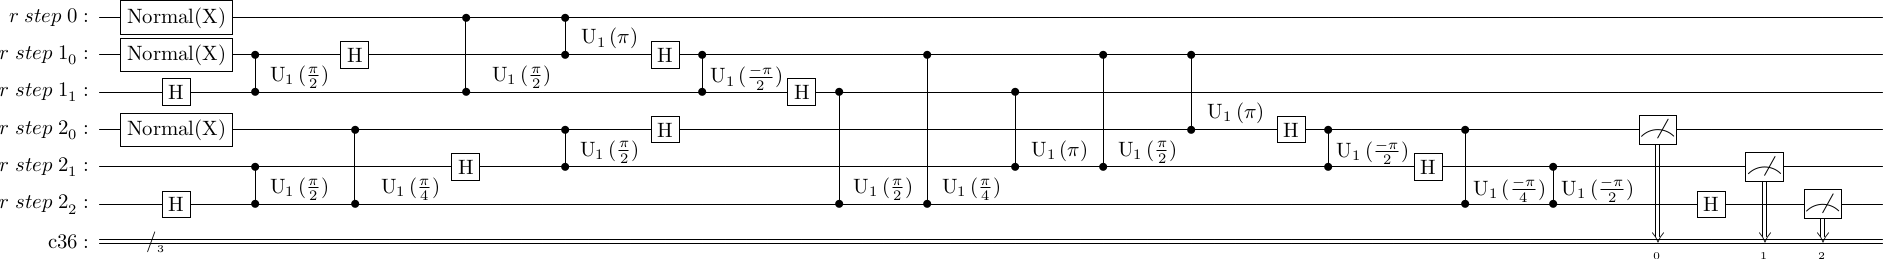

In [42]:
qmc.get_qc().draw("latex")

## Portfolio Selection
## Scenario 1
we found that QAE result in scenario 1 is not stable. not sure the reason yet.

In [33]:

from QuantumMC.quantummc import QuantumMC
from QuantumMC.variable import Variable
import numpy as np

# Initialize QuantumMC object
qmc = QuantumMC()

# Perform quantum walk with 1 and 2 steps, respectively
qw1 = qmc.walk(num_steps = 2, distribution = "Normal", size = 1, name = "r", mu = 0.5, sigma = 1, bounds=(0, 1))
qw2 = qmc.walk(num_steps = 2, distribution = "Normal", size = 1, name = "xi", mu = 0.5, sigma = 1, bounds=(0, 1))

# Perform addition on the two quantum walks
a, b= qmc.arithmetic("add", [qw1.vars[-1], qw2.vars[-1]])

# Load a constant 2 into a variable
var = Variable(2, "constant")
var.load_constant(2)

# Add the constant to the result of the addition of the two quantum walks
qmc.add_variable(var)
a, b= qmc.arithmetic("add", [var, b], False)

# Perform Exponential function with base 2 on the result of the addition
a, b = qmc.arithmetic("power2", [b])

# Perform quantum estimation on the result of the square operation
result = qmc.estimate(0.05, 0.01, b)

# Print result
result

22.666371016076024

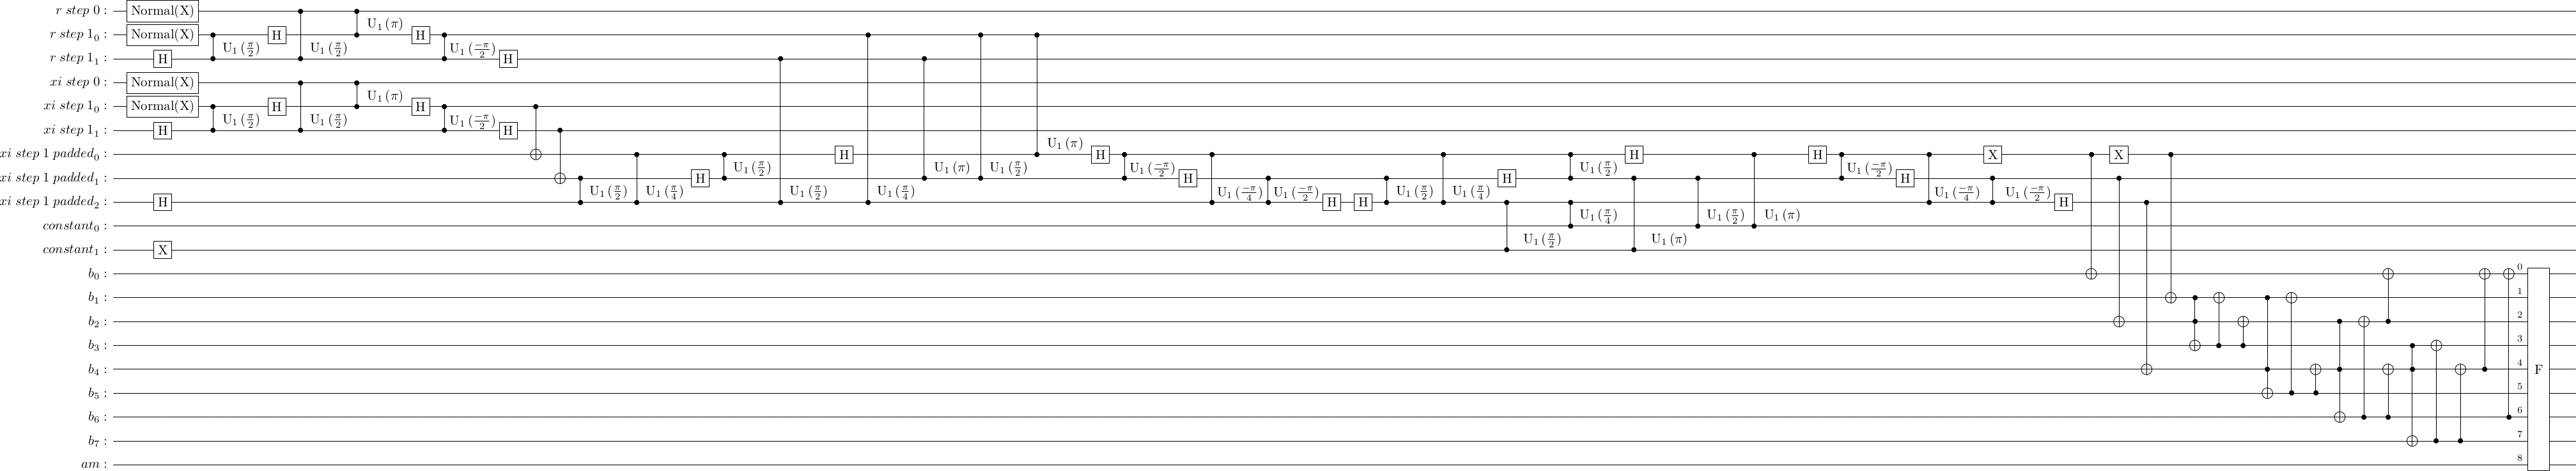

In [27]:
qmc.get_qc().draw("latex")

In [34]:
# qmc = QuantumMC()

# # Perform quantum walk with 1 and 2 steps, respectively
# qw1 = qmc.walk(num_steps = 1, distribution = "Normal", size = 1, name = "r", mu = 0.5, sigma = 0.1, bounds=(0, 1))
from qiskit import *
cr = ClassicalRegister(b.get_register().size)
qmc.get_qc().add_register(cr)
for i in range(cr.size):
    qmc.get_qc().measure(b.get_register()[i], cr[i])
    
num_shots = 1000 #Setting the number of times to repeat measurement
backend = Aer.get_backend("qasm_simulator")
job = execute(qmc.get_qc(), backend, shots=num_shots)
#Get results of program
job_stats = job.result().get_counts()
print(job_stats)

a = 0
for i in job_stats:
    a +=(int(i,2) * job_stats[i])   
#     print(int(i,2))
    
a/num_shots

{'00100000': 263, '00001000': 248, '00010000': 367, '00000100': 64, '01000000': 58}


20.24

## Scenario 2

In [28]:
from QuantumMC.quantummc import QuantumMC
from QuantumMC.variable import Variable
import numpy as np

# Create an instance of the QuantumMC class and assign it to the variable qmc
qmc = QuantumMC()

# Generate a random walk with the specified parameters and assign it to the variable qw1
qw1 = qmc.walk(num_steps = 1, distribution = "Normal", size = 1, name = "r", mu = 0.5, sigma = 1, bounds = (0, 1))

# Generate a second random walk with different parameters and assign it to the variable qw2
qw2 = qmc.walk(num_steps = 1, distribution = "Normal", size = 1, name = "xi", mu = 0.5, sigma = 1, bounds = (0, 1))

# Perform an addition operation on the last element of the vars attribute of qw1 and qw2, and assign the result to the variables a and b
a, b = qmc.arithmetic("add", [qw1.vars[-1], qw2.vars[-1]])

# Create a variable with a size of 1 and a type of "constant", and assign it to the variable var
var = Variable(1, "constant")

# Load a constant value of 1 into the var variable
var.load_constant(1)

# Add the var variable to the list of variables in the qmc object
qmc.add_variable(var)

# Perform an addition operation on the var variable and the b variable, and assign the result to the variables a and b
a, b = qmc.arithmetic("add", [var, b], pad = False)

# Perform a power-of-2 operation on the b variable and assign the result to the variables a and b
a, b = qmc.arithmetic("power2", [b])

a, b = qmc.arithmetic("sub", [b, var])
# Perform a multiplication operation on the first element of the vars attribute of qw1 and the b variable, and assign the result to the variables a, b, and c
a, b, c = qmc.arithmetic("mult", [qw1.vars[0], b])

# Estimate the value of the c variable using Monte Carlo sampling, with the specified error tolerances, and assign the result to the variable result
result = qmc.estimate(0.01, 0.01, c)


In [29]:
result

0.5098378471380566

In [34]:
from qiskit import *
cr = ClassicalRegister(c.get_register().size)
qmc.get_qc().add_register(cr)
for i in range(cr.size):
    qmc.get_qc().measure(c.get_register()[i], cr[i])

In [35]:
num_shots = 1000 #Setting the number of times to repeat measurement
backend = Aer.get_backend("qasm_simulator")
job = execute(qmc.get_qc(), backend, shots=num_shots)
#Get results of program
job_stats = job.result().get_counts()
print(job_stats)

{'001 001': 496, '000 000': 504}


In [36]:
a = 0
for i in job_stats:
    a +=(int(i,2) * job_stats[i])   

ValueError: invalid literal for int() with base 2: '001 001'

In [33]:
a/num_shots

0.508

## Scenario 1

19.440726138686927